In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import math

In [26]:
# load dan fillna
df = pd.read_csv('/kaggle/input/turnkeyid/Sell and Buy.csv', delimiter=';')
df['Swap'] = df['Swap'].fillna(0)

In [27]:
# menghitung profit sebelum adanya pembelian pertama
df['cumulative_balance'] = df['Profit'].cumsum()
df

,Time,Type,Volume,Symbol,Price,Volume.1,Time.1,Price.1,Commission,Swap,Profit,cumulative_balance
0,2024.08.21 20:45:50,Sell,0.02,USDJPY,144.983,0.02,2024.08.21 22:30:00,144.922,-0.14,0.00,0.84,0.84
1,2024.08.21 17:00:16,Buy,0.01,USDJPY,146.663,0.01,2024.08.21 21:00:04,144.867,-0.08,0.00,-12.40,-11.56
2,2024.08.20 02:03:52,Buy,0.01,USDJPY,146.714,0.01,2024.08.21 06:00:00,145.393,-0.08,0.09,-9.09,-20.65
3,2024.08.20 05:56:02,Buy,0.01,GBPJPY,190.730,0.01,2024.08.21 00:27:16,189.053,-0.08,0.11,-11.55,-32.20
4,2024.08.20 05:42:49,Buy,0.01,USDJPY,146.858,0.01,2024.08.20 23:24:44,145.217,-0.08,0.00,-11.30,-43.50
...,...,...,...,...,...,...,...,...,...,...,...,...
872,2023.12.29 14:56:52,Sell,0.01,EURJPY,156.387,0.01,2024.01.02 14:00:04,155.584,-0.08,-0.32,5.66,2468.37
873,2024.01.02 00:01:02,Sell,0.01,GBPJPY,179.136,0.01,2024.01.02 10:45:20,180.468,-0.08,0.00,-9.41,2458.96
874,2023.12.29 09:19:09,Sell,0.01,EURJPY,156.283,0.01,2024.01.02 08:00:03,155.963,-0.08,-0.32,2.26,2461.22
875,2024.01.02 02:48:52,Sell,0.01,USDJPY,141.226,0.01,2024.01.02 04:30:03,141.394,-0.08,0.00,-1.19,2460.03


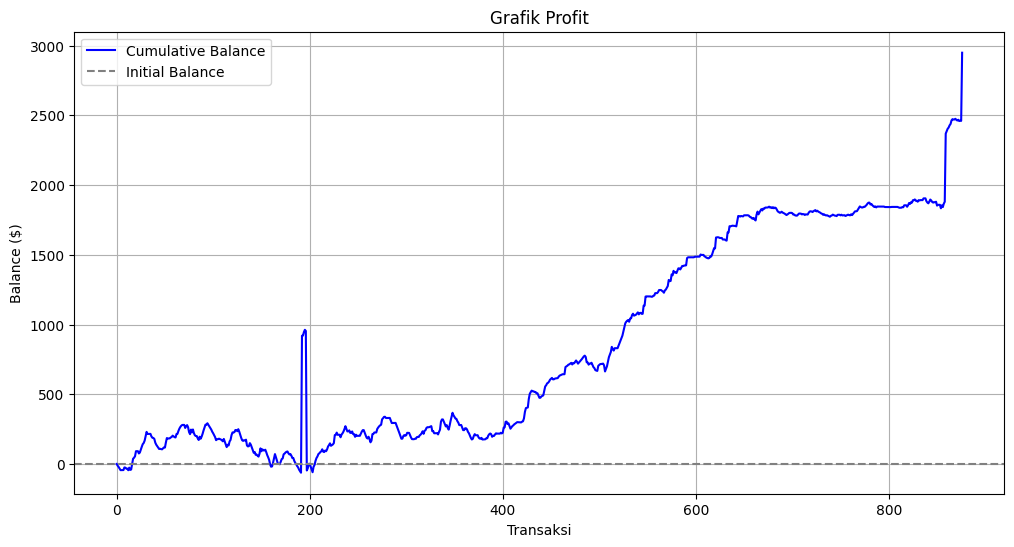

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(df['cumulative_balance'], label='Cumulative Balance', color='blue')
plt.title('Grafik Profit')
plt.xlabel('Transaksi')
plt.ylabel('Balance ($)')
plt.axhline(y=0, color='gray', linestyle='--', label='Initial Balance')
plt.legend()
plt.grid()
plt.show()

In [29]:
# menghitung setelah pembelian pertama
df['cumulative_balance'] = 100 + df['Profit'].cumsum()
df

,Time,Type,Volume,Symbol,Price,Volume.1,Time.1,Price.1,Commission,Swap,Profit,cumulative_balance
0,2024.08.21 20:45:50,Sell,0.02,USDJPY,144.983,0.02,2024.08.21 22:30:00,144.922,-0.14,0.00,0.84,100.84
1,2024.08.21 17:00:16,Buy,0.01,USDJPY,146.663,0.01,2024.08.21 21:00:04,144.867,-0.08,0.00,-12.40,88.44
2,2024.08.20 02:03:52,Buy,0.01,USDJPY,146.714,0.01,2024.08.21 06:00:00,145.393,-0.08,0.09,-9.09,79.35
3,2024.08.20 05:56:02,Buy,0.01,GBPJPY,190.730,0.01,2024.08.21 00:27:16,189.053,-0.08,0.11,-11.55,67.80
4,2024.08.20 05:42:49,Buy,0.01,USDJPY,146.858,0.01,2024.08.20 23:24:44,145.217,-0.08,0.00,-11.30,56.50
...,...,...,...,...,...,...,...,...,...,...,...,...
872,2023.12.29 14:56:52,Sell,0.01,EURJPY,156.387,0.01,2024.01.02 14:00:04,155.584,-0.08,-0.32,5.66,2568.37
873,2024.01.02 00:01:02,Sell,0.01,GBPJPY,179.136,0.01,2024.01.02 10:45:20,180.468,-0.08,0.00,-9.41,2558.96
874,2023.12.29 09:19:09,Sell,0.01,EURJPY,156.283,0.01,2024.01.02 08:00:03,155.963,-0.08,-0.32,2.26,2561.22
875,2024.01.02 02:48:52,Sell,0.01,USDJPY,141.226,0.01,2024.01.02 04:30:03,141.394,-0.08,0.00,-1.19,2560.03


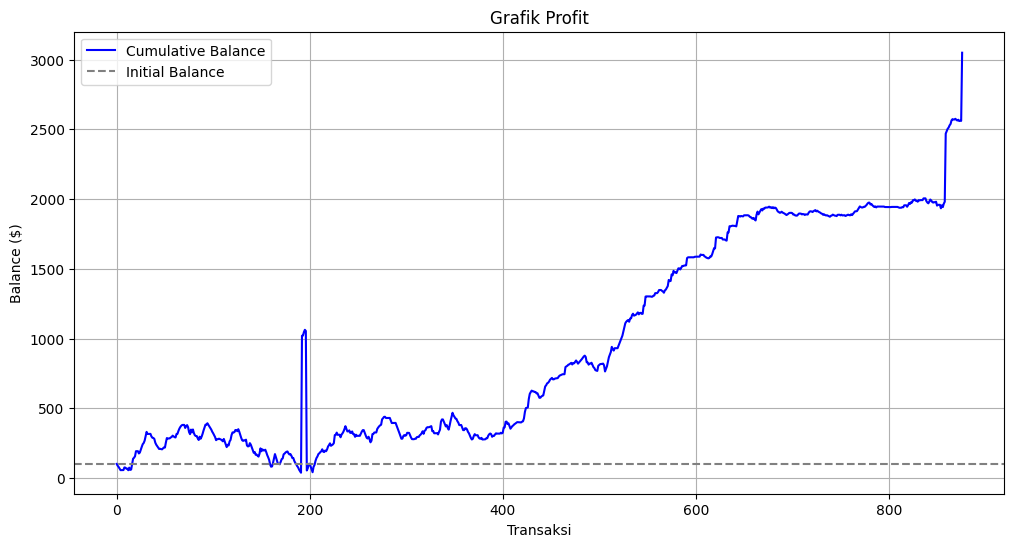

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(df['cumulative_balance'], label='Cumulative Balance', color='blue')
plt.title('Grafik Profit')
plt.xlabel('Transaksi')
plt.ylabel('Balance ($)')
plt.axhline(y=100, color='gray', linestyle='--', label='Initial Balance')
plt.legend()
plt.grid()
plt.show()

In [32]:
# menghitung maximum cumulative balance dan menghitung penurunan drastis
max_balance = df['cumulative_balance'].expanding().max()
drawdown = max_balance - df['cumulative_balance']
max_drawdown = drawdown.max()
max_balance

0       100.84
1       100.84
2       100.84
3       100.84
4       100.84
        ...   
872    2575.05
873    2575.05
874    2575.05
875    2575.05
876    3048.67
Name: cumulative_balance, Length: 877, dtype: float64

In [35]:
# pertumbuhan
take_max_growth = df['cumulative_balance'].iloc[-1] #mengambil nilai tertinggi cumulative balance
growth_profit = take_max_growth - 100 #mengurangi max growth dari modal awal
growth_profit

2948.67

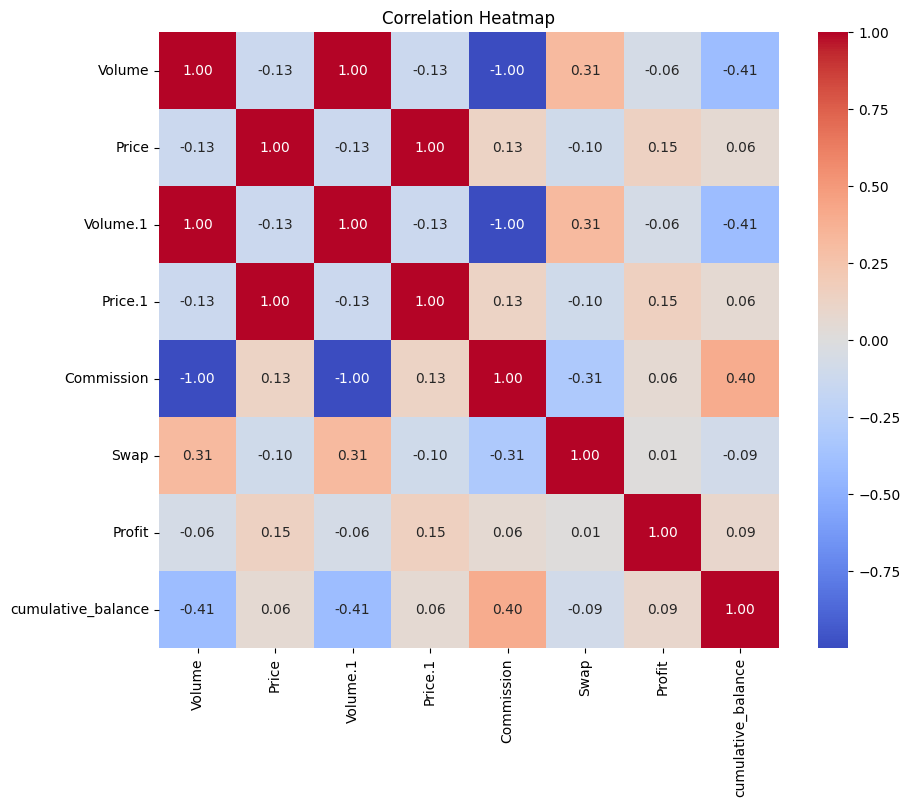

In [37]:
numerical_data = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_data.corr()

# melihat corrmap setiap variable
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

In [44]:
# ekstraksi fitur waktu
df['Time'] = pd.to_datetime(df['Time'])

df['Year'] = df['Time'].dt.year
df['Month'] = df['Time'].dt.month
df['Day'] = df['Time'].dt.day
df['DayOfWeek'] = df['Time'].dt.dayofweek
df['Hour'] = df['Time'].dt.hour

In [71]:
encoded_data = df.copy()
for column in encoded_data.select_dtypes(include=['object']).columns:
    encoded_data[column] = LabelEncoder().fit_transform(encoded_data[column])

In [72]:
encoded_data = encoded_data.fillna(0)

In [73]:
# Pilih X dan y
X = encoded_data.drop(columns=['Profit', 'Time', 'Time.1'])  # Semua fitur kecuali target
y = encoded_data['Profit']

In [74]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X, y)
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Fitur yang paling penting:")
print(feature_importances)

Fitur yang paling penting:
               Feature  Importance
8   cumulative_balance    0.217110
5              Price.1    0.124752
1               Volume    0.110383
6           Commission    0.094636
2               Symbol    0.083362
3                Price    0.078981
0                 Type    0.078832
4             Volume.1    0.066247
11                 Day    0.056685
13                Hour    0.031072
12           DayOfWeek    0.026186
7                 Swap    0.017926
10               Month    0.013470
9                 Year    0.000359


In [75]:
# pilih fitur eksogen dg threshold > 0.05
selected_features = feature_importances[feature_importances['Importance'] > 0.05]['Feature'].tolist()
exogenous_data = encoded_data[selected_features]
exogenous_data

,cumulative_balance,Price.1,Volume,Commission,Symbol,Price,Type,Volume.1,Day
0,100.84,144.922,0.02,-0.14,2,144.983,2,0.02,21
1,88.44,144.867,0.01,-0.08,2,146.663,1,0.01,21
2,79.35,145.393,0.01,-0.08,2,146.714,1,0.01,20
3,67.80,189.053,0.01,-0.08,1,190.730,1,0.01,20
4,56.50,145.217,0.01,-0.08,2,146.858,1,0.01,20
...,...,...,...,...,...,...,...,...,...
872,2568.37,155.584,0.01,-0.08,0,156.387,2,0.01,29
873,2558.96,180.468,0.01,-0.08,1,179.136,2,0.01,2
874,2561.22,155.963,0.01,-0.08,0,156.283,2,0.01,29
875,2560.03,141.394,0.01,-0.08,2,141.226,2,0.01,2


# SARIMAX

In [76]:
# persiapan data dengan Time sbg index
profit_series = encoded_data.set_index('Time')['Profit']  
exogenous_data = exogenous_data.set_index(encoded_data['Time']) 

In [77]:
exogenous_data

,cumulative_balance,Price.1,Volume,Commission,Symbol,Price,Type,Volume.1,Day
Time,,,,,,,,,
2024-08-21 20:45:50,100.84,144.922,0.02,-0.14,2,144.983,2,0.02,21
2024-08-21 17:00:16,88.44,144.867,0.01,-0.08,2,146.663,1,0.01,21
2024-08-20 02:03:52,79.35,145.393,0.01,-0.08,2,146.714,1,0.01,20
2024-08-20 05:56:02,67.80,189.053,0.01,-0.08,1,190.730,1,0.01,20
2024-08-20 05:42:49,56.50,145.217,0.01,-0.08,2,146.858,1,0.01,20
...,...,...,...,...,...,...,...,...,...
2023-12-29 14:56:52,2568.37,155.584,0.01,-0.08,0,156.387,2,0.01,29
2024-01-02 00:01:02,2558.96,180.468,0.01,-0.08,1,179.136,2,0.01,2
2023-12-29 09:19:09,2561.22,155.963,0.01,-0.08,0,156.283,2,0.01,29


In [78]:
# dibagi 0.8 train, 0.2 test untuk profit_series dan exogen
train_size = int(len(profit_series) * 0.8)
train, test = profit_series[:train_size], profit_series[train_size:]
exog_train, exog_test = exogenous_data[:train_size], exogenous_data[train_size:]

In [79]:
# train SARIMAX
sarimax_model = SARIMAX(train, exog=exog_train, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
sarimax_result = sarimax_model.fit()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsm

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.47429D+00    |proj g|=  1.31078D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13      2     16      1     0     0   5.193D-02   5.474D+00
  F =   5.4741922644788907     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [80]:
# test
forecast = sarimax_result.forecast(steps=len(test), exog=exog_test)
forecast

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


701    -24.484739
702     -9.872136
703    -32.247151
704    -25.830930
705    -31.407689
          ...    
872    377.960643
873    367.328240
874    366.635270
875    369.507803
876    834.113678
Name: predicted_mean, Length: 176, dtype: float64

In [82]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 125.3609020592909
Root Mean Squared Error (RMSE): 153.83235135308814


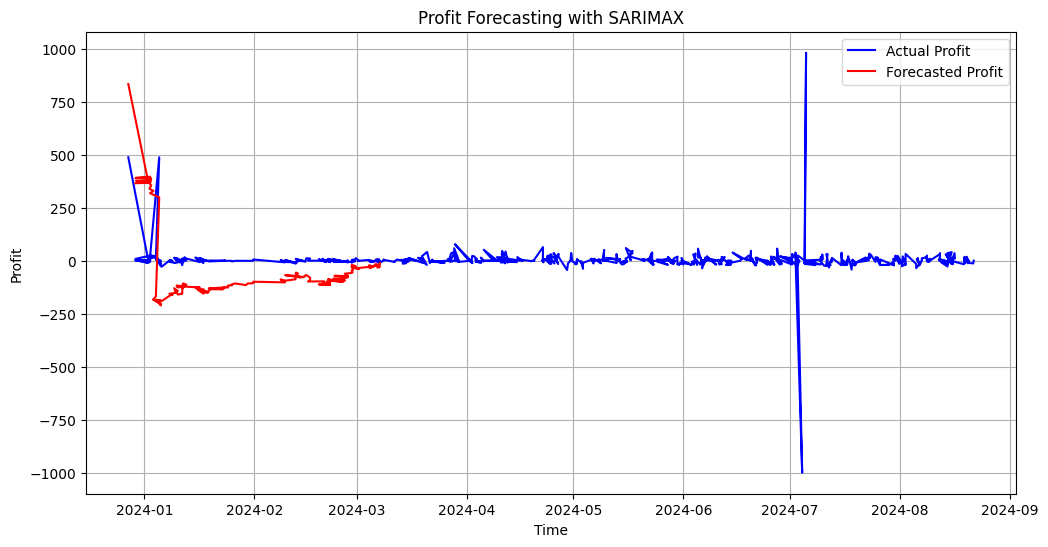

In [107]:
plt.figure(figsize=(12, 6))
plt.plot(profit_series, label='Actual Profit', color='blue')
plt.plot(test.index, forecast, label='Forecasted Profit', color='red')
plt.legend()
plt.title('Profit Forecasting with SARIMAX')
plt.xlabel('Time')
plt.ylabel('Profit')
plt.grid()
plt.show()

# LSTM (Long Short Term Memory),

In [91]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [90]:
profit_data = df['Profit'].values
profit_data = profit_data.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
profit_scaled = scaler.fit_transform(profit_data)

In [97]:
time_step = 10
X, y = create_dataset(profit_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [131]:
# modeling LSTM
model = Sequential()

model.add(LSTM(units=110, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=110, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Melatih model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0928 - val_loss: 0.0077
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0045 - val_loss: 0.0011
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0032 - val_loss: 2.3469e-04
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0022 - val_loss: 9.3996e-05
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0051 - val_loss: 5.7772e-05
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0022 - val_loss: 5.5795e-05
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0017 - val_loss: 1.1131e-04
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0030 - val_loss: 4.8602e-04
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0021 - val_loss: 1.1288e-04
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0020 - val_loss: 8.3489e-05
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0015 - val_loss: 5.6222e-05
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━

In [132]:
y_pred = model.predict(X_test)

y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
# y_pred_rescaled, '\n', y_test_rescaled

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


In [133]:
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = math.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 10.756501049831
Root Mean Squared Error (RMSE): 37.934296257875985


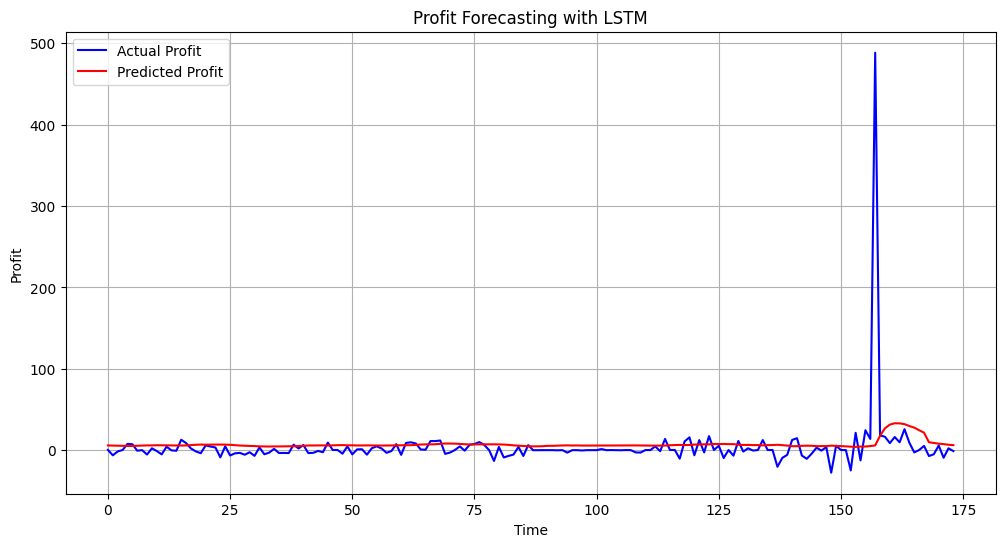

In [134]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Profit', color='blue')
plt.plot(y_pred_rescaled, label='Predicted Profit', color='red')
plt.legend()
plt.title('Profit Forecasting with LSTM')
plt.xlabel('Time')
plt.ylabel('Profit')
plt.grid()
plt.show()

In [135]:
model.save('/kaggle/working/LSTM.h5')